In [1]:
import torch
import torch.nn.functional as F
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt

## **Understanding Architecture**

> **GOAL:** <br>
> Given 3 previous characters, predict 4th character  <br>
> This system will be our base archictecture that generates names

> **NEURAL NETWORK:**  <br>
> 6 embeddings ---> 100 neurons (HIDDEN LAYER) ---> 27 neurons (OUTPUT LAYER) <br>
* We have 6 embeddings because 2 coming from each previous-character<br>
* and 27 neurons in output layer because 26 characters in english + '.' that marks start & end of a name

## **Prepare Dataset**

In [2]:
words = open("./names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# make string to int and reverse mapping
chars = sorted(list(set(''.join(words)))) # gets unique chars (a,b,c...,y,z)
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0  # '.' char used to mark the start/end of a name
itos = {i:s for s,i in stoi.items()} # reverse mapping

stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [4]:
# Build dataset, first 5 names for now
# we will use 3 context characters to predict next/4th character
# so we are storing X which is the 3 context characters
# and Y, the expected character

block_size=3
X,Y = [],[]
for w in words[:5]:
    print(w+'.')
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in  context), '--->', itos[ix])
        context=context[1:]+[ix]

X=torch.tensor(X)
Y=torch.tensor(Y)

emma.
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia.
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava.
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella.
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia.
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [5]:
X.shape, Y.shape
# from x.shape we get to know we have 32 mappings from the first 5 names

(torch.Size([32, 3]), torch.Size([32]))

In [6]:
X.dtype, Y.dtype

(torch.int64, torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [8]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

## **Understanding Embedding/Lookup Table**

In [9]:
X.shape

torch.Size([32, 3])

In [10]:
C = torch.randn(27,2) # lookup table/embedder

In [11]:
emb = C[X] # embedding process
emb.shape # output shape

torch.Size([32, 3, 2])

In [12]:
# right now emb represents the mapping:  row/record -> index -> embedding
# which is why it has shape [32,3,2]

# we have to now convert this shape  to [32,6] to be able to multiply with weights of neural network
# we do so by using .cat which results in removing the intermediate index
# so now mapping is just:  row/record -> embeddings

torch.cat( [emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape

torch.Size([32, 6])

In [13]:
# this command also does the same thing
emb.view(32,6).shape

torch.Size([32, 6])

In [14]:
#verification
emb.view(32,6) == torch.cat( [emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [15]:
# another way, incase we don't know total rows
emb.view(-1,6).shape

torch.Size([32, 6])

## **Neural Network**

In [16]:
# INITIALIZE NETWORK
g = torch.Generator().manual_seed(2147483647) # a fixed seed for consistent results across repeated runs

C = torch.randn((27,2), generator=g) # lookup table/embedder
W1 = torch.randn((6,100), generator=g) # Hidden layer of 100 neurons that accept 6 inputs each
b1 = torch.randn(100, generator=g) # bias
W2 = torch.randn((100,27), generator=g) # Output layer of 27 neurons that accept 100 inputs each
b2 = torch.rand(27, generator=g) # bias
parameters = [C,W1,b1,W2,b2] # trainable parameters

In [17]:
for p in parameters:
    p.requires_grad=True  # enable gradient tracking for the trainable parameters

In [18]:
# stat: number of trainable parameters
sum(p.nelement() for p in parameters)

3481

> Forward Pass -> Loss Calc -> Backward Pass -> Optimize -> Repeat

In [19]:
for _ in range(100):
    # FORWARD PASS
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)  # embeddings passed through HIDDEN layer
    logits = h @ W2 + b2 # passed through OUTPUT layer

    # LOSS CALCULATION
    loss = cross_entropy(logits, Y)  # this is equivalent to applying softmax to logits, then doing negative-log-likelihood loss calculation
    print(loss.item())

    # zero_grad
    for p in parameters:
        p.grad = None

    # BACKWARD PASS
    loss.backward()

    # OPTIMIZE TRAINABLE PARAMETERS
    for p in parameters:
        p.data += -0.1 * p.grad

17.082719802856445
12.862615585327148
10.728668212890625
8.967991828918457
7.639877796173096
6.726390838623047
5.975147247314453
5.343568325042725
4.80079460144043
4.326159477233887
3.904778003692627
3.5284531116485596
3.1937386989593506
2.898573160171509
2.640528678894043
2.415578603744507
2.2191145420074463
2.0478219985961914
1.9001200199127197
1.7751595973968506
1.6708712577819824
1.5828299522399902
1.5058629512786865
1.4361298084259033
1.3713361024856567
1.310139775276184
1.251733422279358
1.1956814527511597
1.1418606042861938
1.0903983116149902
1.0415613651275635
0.9955949783325195
0.9525876641273499
0.9124341011047363
0.8748853206634521
0.8396298885345459
0.80636066198349
0.7748074531555176
0.7447487711906433
0.7160143256187439
0.6884839534759521
0.6620863080024719
0.6368054151535034
0.6126888394355774
0.589855968952179
0.5684973001480103
0.5488439202308655
0.5311039090156555
0.5153754949569702
0.5015925765037537
0.4895433485507965
0.47894570231437683
0.4695192277431488
0.4610263

## **Choosing a good learning rate**

In [20]:
# Build Dataset (all names this time, not just 5)

block_size=3
X,Y = [],[]
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context=context[1:]+[ix]

X=torch.tensor(X)
Y=torch.tensor(Y)

In [21]:
# INITIALIZE NETWORK
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27,2), generator=g) # lookup table/embedder
W1 = torch.randn((6,100), generator=g) # Hidden layer of 100 neurons that accept 6 inputs each
b1 = torch.randn(100, generator=g) # bias
W2 = torch.randn((100,27), generator=g) # Output layer of 27 neurons that accept 100 inputs each
b2 = torch.rand(27, generator=g) # bias
parameters = [C,W1,b1,W2,b2] # trainable parameters

In [22]:
for p in parameters:
    p.requires_grad=True  # enable gradient tracking for the trainable parameters

# stat: number of trainable parameters
sum(p.nelement() for p in parameters)

3481

In [23]:
lre = torch.linspace(-3,0,1000) # learning rate exponents
lrs = 10**lre # learning rates
lrs[:50] # view first 50

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014])

In [24]:
lri = [] # store all learning rate exponents
lossi = [] # store all losses

for i in range(1000):

    # minibatch
    ix = torch.randint(0,X.shape[0],(32,))

    # FORWARD PASS
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)  # embeddings passed through HIDDEN layer
    logits = h @ W2 + b2 # passed through OUTPUT layer

    # LOSS CALCULATION
    loss = cross_entropy(logits, Y[ix])  # this is equivalent to applying softmax to logits, then doing negative-log-likelihood loss calculation
    #print(loss.item())

    # zero_grad
    for p in parameters:
        p.grad = None

    # BACKWARD PASS
    loss.backward()

    lr=lrs[i]
    # OPTIMIZE TRAINABLE PARAMETERS
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

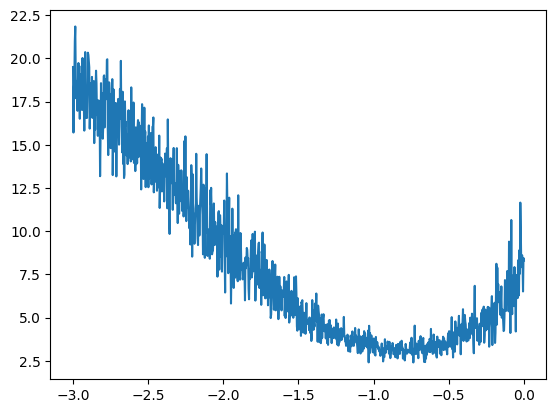

In [25]:
plt.plot(lri,lossi) # plot learning rate exponents vs loss

In [26]:
# hence a good learning rate exponents would be near -1
# 10**-1 = 0.1
# hence 0.1 is a good learning rate

> final model making with train,dev,test split validation in "final_model.ipynb"